# Convolutional Neural Network

Construccion, afinamiento, entrenamiento y pruebas de una red neuronal convolucional clasificadora de images.

### Librearias

In [1]:
# Librerias de TensorFlow y Keras para construccion de la red neuronal
import tensorflow as tf
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import regularizers
from keras import losses

# Libreria para procesamiento y aumento de datos de imágenes
from keras.preprocessing.image import ImageDataGenerator

# Libreria para afinamiento de hiperparametros
import keras_tuner as kt

# Libreria para manejo de rutas y operaciones del sistema de archivos
import os

# Libreria para manejo de matrices y operaciones matematicas
import numpy as np

# Librerias para graficar
import matplotlib.pyplot as plt
import seaborn as sns

# Libreria para metricas de evaluacion
from sklearn.metrics import classification_report, confusion_matrix

# Lireria para manejo de imagenes
from PIL import Image

### Data Augmentation

In [2]:
# Resolucion objetivo de las imagenes
# 100x100 pixeles
# 3 canales de color (RGB)
target_width = 100
target_height = 100
target_size = (target_width, target_height)
target_batch_size = 32

In [3]:
train_datagen = ImageDataGenerator(
    rescale = 1.0/255,
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

**Generador para imagenes de entrenamiento**

In [4]:
training_data = os.path.join(os.getcwd(), 'dataset/split/train')

train_generator = train_datagen.flow_from_directory(
    training_data,
    target_size = target_size,
    batch_size = target_batch_size,
    class_mode = 'categorical',
)

train_batch_qty = len(train_generator)
print(f"Number of batches: {train_batch_qty}")

Found 350 images belonging to 5 classes.


Number of batches: 11


**Generador para imagenes de testeo**

In [5]:
test_datagen = ImageDataGenerator(rescale = 1.0/255)

testing_data = os.path.join(os.getcwd(), 'dataset/split/test')

test_generator = test_datagen.flow_from_directory(
    testing_data,
    target_size = target_size,
    batch_size = target_batch_size,
    class_mode = 'categorical',
    shuffle=False
)

test_batch_qty = len(test_generator)
print(f"Number of batches: {test_batch_qty}")

Found 100 images belonging to 5 classes.


Number of batches: 4


**Generador para imagenes de validacion**

In [6]:
valid_datagen = ImageDataGenerator(rescale = 1.0/255)

validation_data = os.path.join(os.getcwd(), 'dataset/split/val')

valid_generator = valid_datagen.flow_from_directory(
    validation_data,
    target_size = target_size,
    batch_size = target_batch_size,
    class_mode = 'categorical',
    shuffle = False
)

val_batch_qty = len(valid_generator)
print(f"Number of batches: {val_batch_qty}")

Found 50 images belonging to 5 classes.
Number of batches: 2


### Visualizar muestras del Data Augmentation

In [7]:
def show_sample(generator, class_labels, split_type):
    # Crear una figura
    fig, ax = plt.subplots(1, 5, figsize=(12, 4))
    idx = 0

    # Iterar sobre las imagenes y mostrarlas
    for i in range(5):
        label = class_labels[np.argmax(generator[0][1][idx])]
        ax[i].set_title(f"{label}")
        ax[i].imshow(generator[0][0][idx][:,:,:])
        ax[i].axis('off')
        idx += 1
    
    plt.tight_layout()
    plt.suptitle(f"Muestra de Imagenes de {split_type}", size=20)

**Mapeo de etiquetas para cada clase**

In [8]:
# Cantidad de clases
num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")

Number of classes: 5


In [9]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mapping:")
for key, value in labels.items():
    print(f"{key}: {value}")

Label Mapping:
0: Brachiosaurus
1: Pteranodon
2: Stegosaurus
3: Triceratops
4: Tyrannosaurus


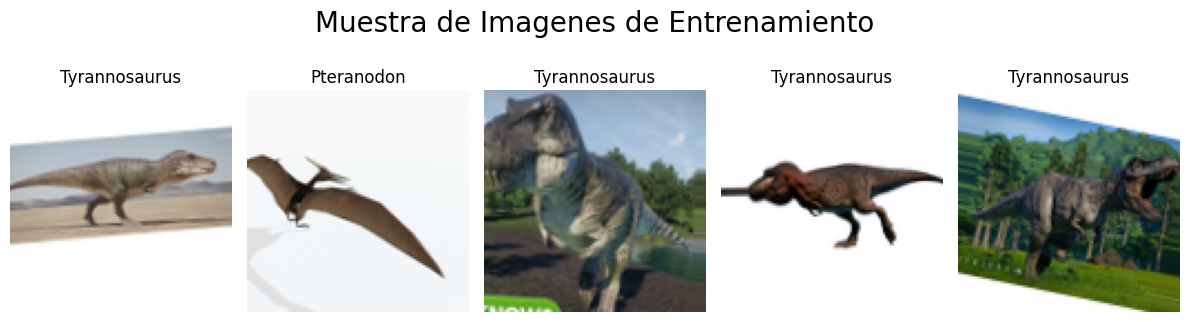

In [10]:
show_sample(train_generator, labels, "Entrenamiento")

## Modelado de la Red Neronal

### Construccion del Modelo

**Rango de hiperparametros**

In [11]:
# Cantidad de Filtros
min_units = 16
max_units = 256

# Tamaño del regularizador L2
min_reg = 1.0e-5
max_reg = 1.0

# Tasa de Dropout
min_dropout = 0.1
max_dropout = 0.7

# Input shape
input = (target_width, target_height, 3)

**Constructor de modelos**

In [12]:
def model_builder(hp):
    model = Sequential()

    # Hiperparametros fijos para el modelo
    hp_reg = hp.Float('regularizer', min_value=min_reg, max_value=max_reg, sampling='log')
    hp_dropout = hp.Float('dropout_rate', min_value=min_dropout, max_value=max_dropout, step=0.1)
    

    # Primera capa
    model.add(Conv2D(filters=hp.Int('filters', min_value=min_units, max_value=max_units, step=16), 
                     kernel_size=(3,3), 
                     kernel_regularizer=regularizers.l2(hp_reg), 
                     padding='same', 
                     input_shape=input))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    

    # Second layer
    model.add(Conv2D(filters=hp.Int('filters', min_value=min_units, max_value=max_units, step=16), 
                     kernel_size=(3,3), 
                     kernel_regularizer=regularizers.l2(hp_reg), 
                     padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(hp_dropout))

    # Third layer
    model.add(Conv2D(filters=hp.Int('filters', min_value=min_units, max_value=max_units, step=16),
                     kernel_size=(3,3), 
                     kernel_regularizer=regularizers.l2(hp_reg), 
                     padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(hp_dropout))

    # Fourth layer
    model.add(Conv2D(filters=hp.Int('filters', min_value=min_units, max_value=max_units, step=16), 
                     kernel_size=(3,3), 
                     kernel_regularizer=regularizers.l2(hp_reg), 
                     padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(hp_dropout))

    # Fifth layer
    model.add(Conv2D(filters=hp.Int('filters', min_value=min_units, max_value=max_units, step=16), 
                     kernel_size=(3,3), 
                     kernel_regularizer=regularizers.l2(hp_reg), 
                     padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    # Sixth layer
    model.add(Conv2D(filters=hp.Int('filters', min_value=min_units, max_value=max_units, step=16), 
                     kernel_size=(3,3), 
                     kernel_regularizer=regularizers.l2(hp_reg), 
                     padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(hp_dropout))

    # Flatten the output
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))
    
    optimizer = Adam(learning_rate=0.001)

    model.compile(optimizer = optimizer,
                  loss = losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
    
    return model

### Afinado del modelo

**Afinadores de hiperparametros**

In [13]:
tuner = kt.Hyperband(
    hypermodel = model_builder,
    objective = 'val_accuracy',
    max_epochs = 10,
    factor = 3,
    directory = 'tuner_logs',
    project_name = 'cnn_hyperband'
)

tuner.search_space_summary()

Reloading Tuner from tuner_logs\cnn_hyperband\tuner0.json
Search space summary
Default search space size: 3
regularizer (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 1.0, 'step': None, 'sampling': 'log'}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.7, 'step': 0.1, 'sampling': 'linear'}
filters (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 16, 'sampling': 'linear'}


**Callback para optimizacion de busqueda**

In [14]:
# Callbacks para detener el entrenamiento si no hay mejora en la funcion de perdida
stop_early = EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=10)

**Busqueda de los mejores hiperparametros**

In [15]:
# Buscar los mejores hiperparametros con el afinador Hyperband
tuner.search(train_generator, epochs=10, validation_data=valid_generator, callbacks=[stop_early, reduce_lr])

# Obtener los mejores hiperparametros encontrados por el afinador Hyperband
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

**Arquitectura de la CNN Resultante**

In [16]:
cnn_model = tuner.hypermodel.build(best_hps)
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 96)      2688      
                                                                 
 activation (Activation)     (None, 100, 100, 96)      0         
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 96)     384       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 96)      83040     
                                                                 
 activation_1 (Activation)   (None, 100, 100, 96)      0         
                                                                 
 batch_normalization_1 (Batc  (None, 100, 100, 96)     384       
 hNormalization)                                        

### Entrenamiento del modelo Optimizado

In [17]:
history = cnn_model.fit(train_generator, epochs=125, validation_data=valid_generator, verbose=1)

Epoch 1/125
11/11 [==============================] - 8s 258ms/step - loss: 5.7433 - accuracy: 0.2800 - val_loss: 2.6869 - val_accuracy: 0.2200
Epoch 2/125
11/11 [==============================] - 1s 66ms/step - loss: 2.9127 - accuracy: 0.3771 - val_loss: 2.3852 - val_accuracy: 0.2400
Epoch 3/125
11/11 [==============================] - 1s 66ms/step - loss: 2.4394 - accuracy: 0.3886 - val_loss: 3.4808 - val_accuracy: 0.2400
Epoch 4/125
11/11 [==============================] - 1s 66ms/step - loss: 2.3947 - accuracy: 0.4371 - val_loss: 3.1922 - val_accuracy: 0.2800
Epoch 5/125
11/11 [==============================] - 1s 66ms/step - loss: 2.3536 - accuracy: 0.4629 - val_loss: 3.9154 - val_accuracy: 0.2400
Epoch 6/125
11/11 [==============================] - 1s 65ms/step - loss: 2.0040 - accuracy: 0.4457 - val_loss: 5.1655 - val_accuracy: 0.2000
Epoch 7/125
11/11 [==============================] - 1s 66ms/step - loss: 1.8370 - accuracy: 0.5114 - val_loss: 3.6319 - val_accuracy: 0.2400
Epoch

**Desempeño del entrenamiento**

In [18]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

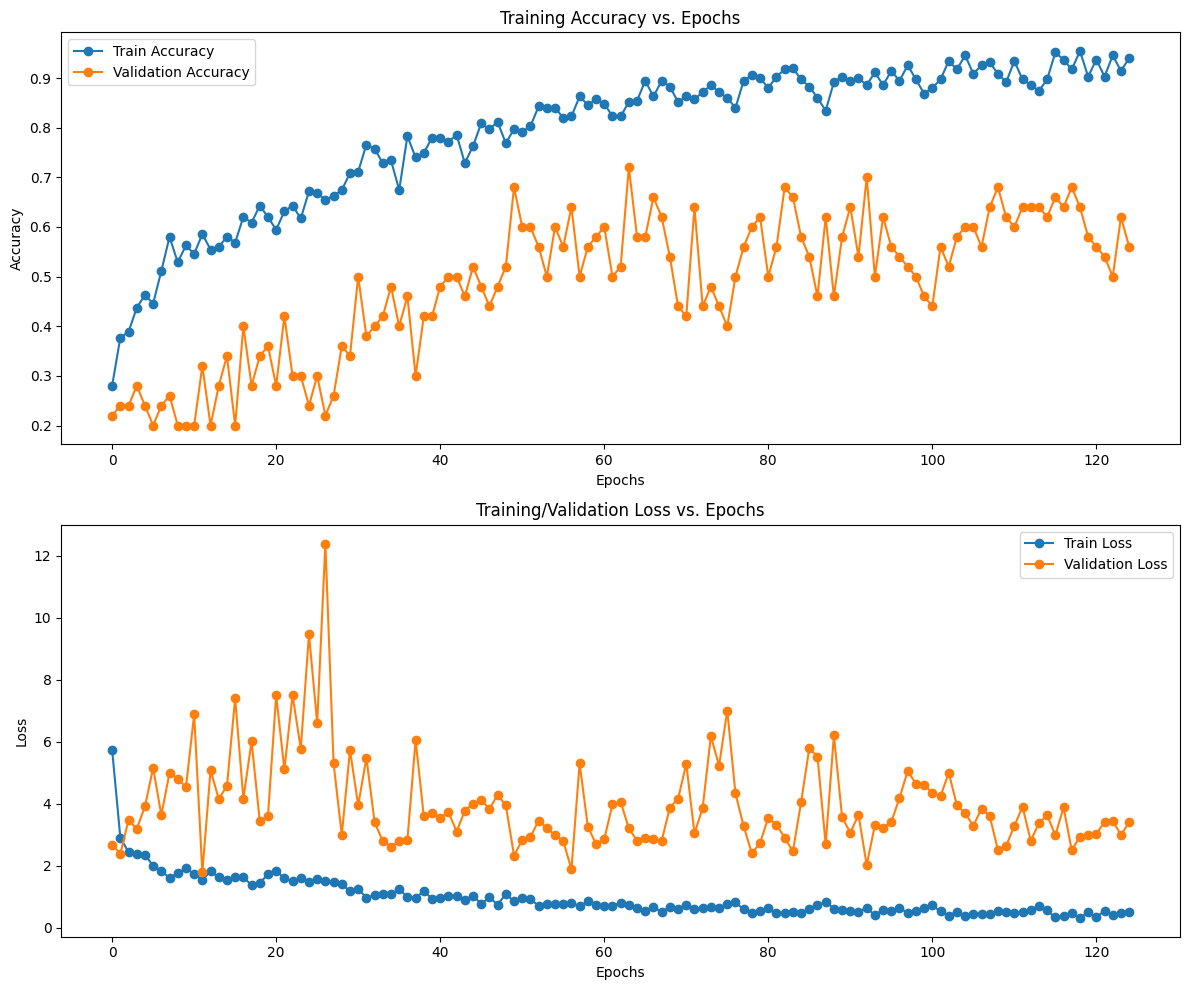

In [19]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

### Rendimiento del Modelo

**Predicciones**

In [20]:
# Evaluar el modelo con el conjunto de testeo
predictions = cnn_model.predict(test_generator)

4/4 [==============================] - 0s 62ms/step


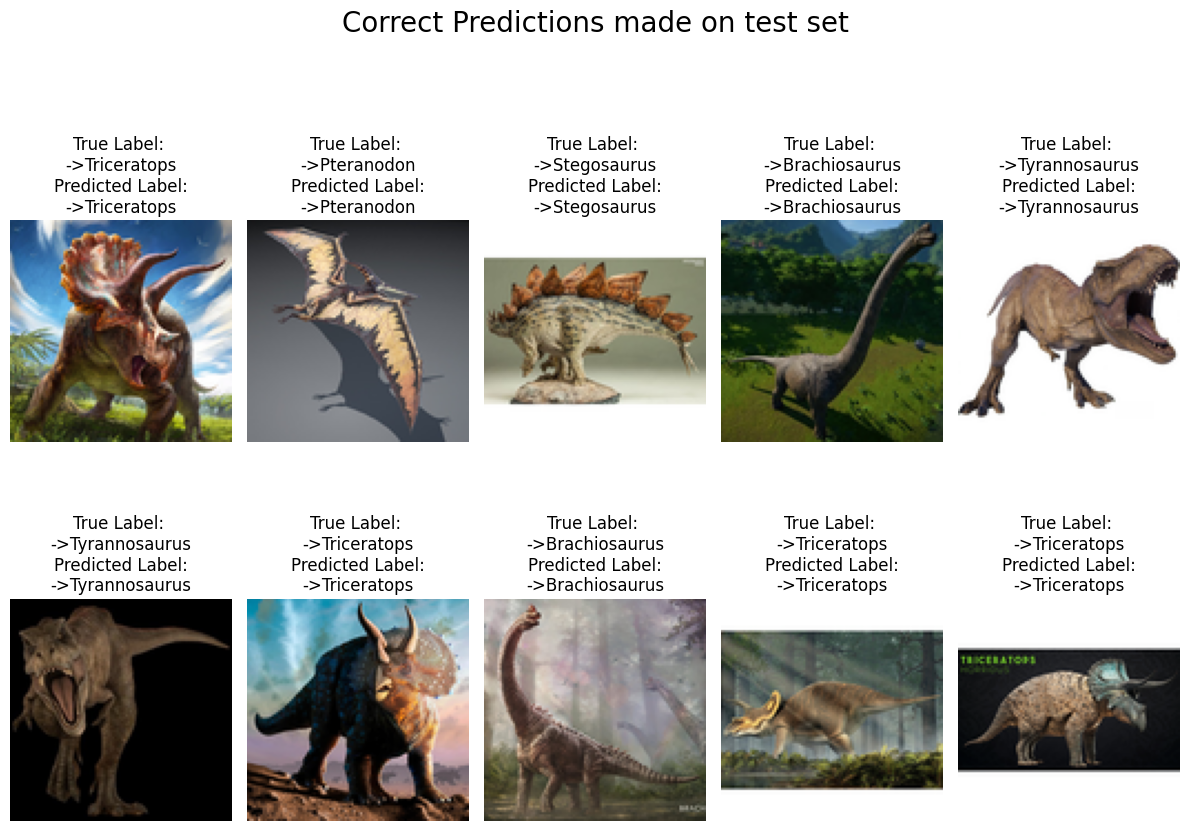

In [33]:
# Get the true labels from the test generator
true_labels = test_generator.classes

# Convert predictions to label indices
predicted_indices = np.argmax(predictions, axis=1)

# Find indices where the predictions match the true labels
correct_indices = np.where(predicted_indices == true_labels)[0]

# Shuffle the indices to get a random sample
np.random.shuffle(correct_indices)

# Select the first 10 correct predictions
sample_indices = correct_indices[:10]

# Retrieve the file names for these correct predictions
test_images = test_generator.filenames
test_img_correct = np.asarray(test_images)[sample_indices]

# Plot the images with correct predictions
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        image_idx = sample_indices[idx]
        true_label = labels[true_labels[image_idx]]
        predicted_label = labels[predicted_indices[image_idx]]
        ax[i, j].set_title(f"True Label: \n->{true_label}\nPredicted Label:\n->{predicted_label}")
        
        img_path = os.path.join(test_generator.directory, test_img_correct[idx])
        img = Image.open(img_path)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")
        idx += 1

plt.suptitle('Correct Predictions made on test set', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Evaluacion y Metricas**

In [22]:
# Obtener las metricas de evaluacion
eval_result = cnn_model.evaluate(test_generator)
for metric, value in zip(cnn_model.metrics_names, eval_result):
    print(f'{metric}: {value}')

4/4 [==============================] - 0s 12ms/step - loss: 2.5531 - accuracy: 0.7400
loss: 2.5530710220336914
accuracy: 0.7400000095367432


In [23]:
# predicciones y etiquetas verdaderas
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

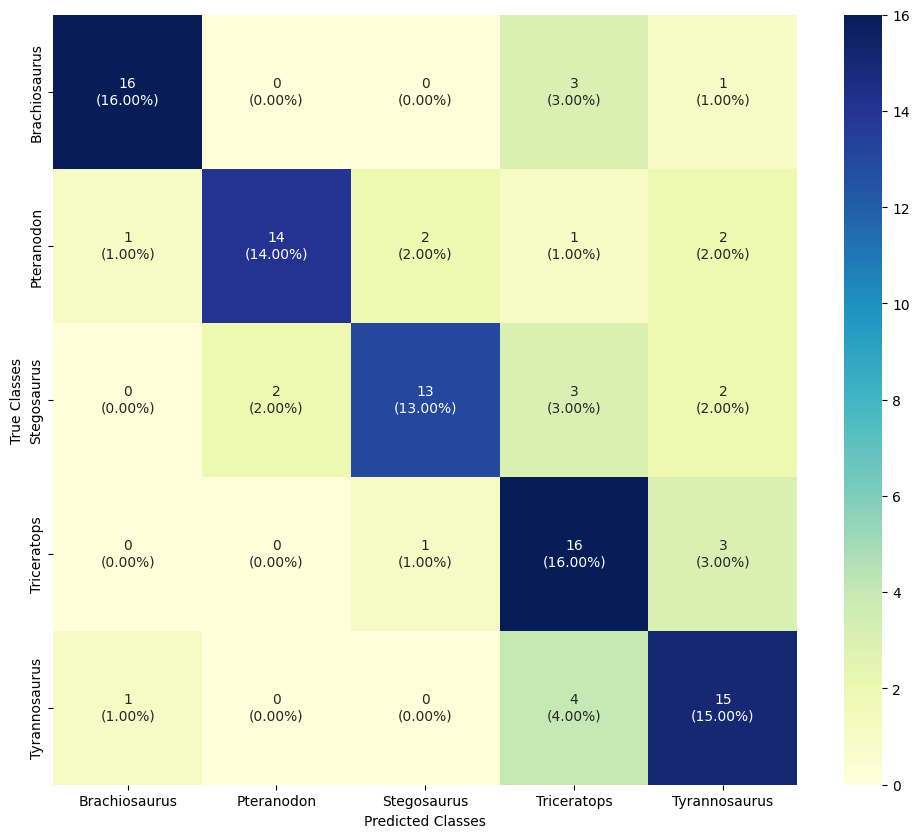

In [24]:
# Matriz de confusion
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(num_classes, num_classes)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

**Reporte de clasificacion**

In [25]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

               precision    recall  f1-score   support

Brachiosaurus       0.89      0.80      0.84        20
   Pteranodon       0.88      0.70      0.78        20
  Stegosaurus       0.81      0.65      0.72        20
  Triceratops       0.59      0.80      0.68        20
Tyrannosaurus       0.65      0.75      0.70        20

     accuracy                           0.74       100
    macro avg       0.76      0.74      0.74       100
 weighted avg       0.76      0.74      0.74       100



**Predicciones Erroneas**

In [26]:
errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

In [27]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

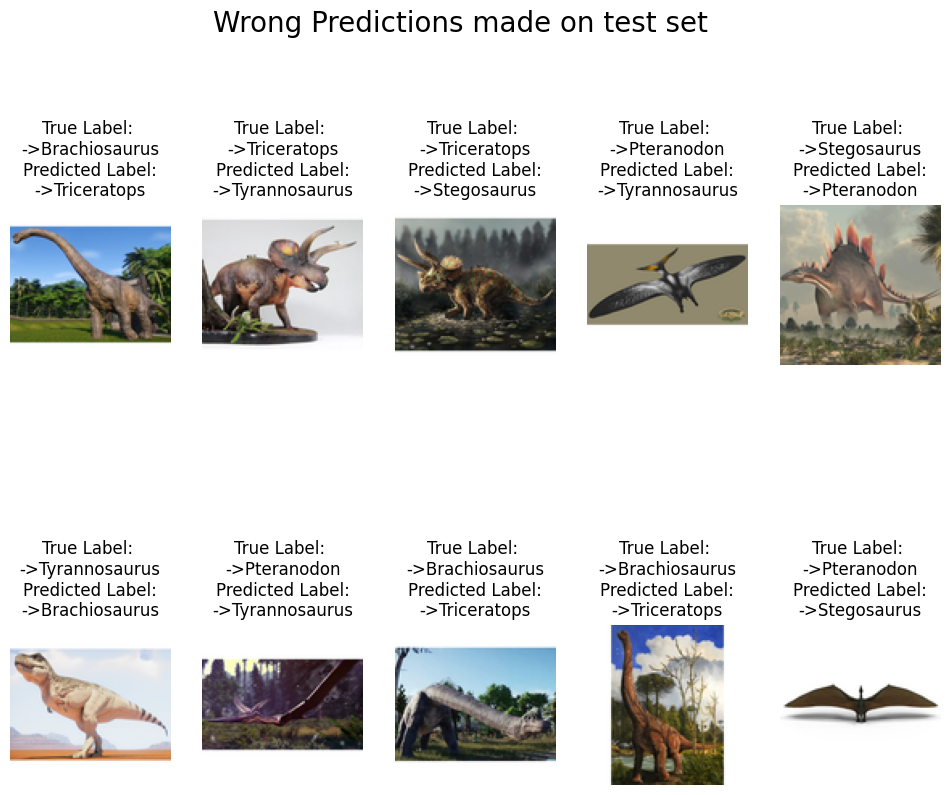

In [30]:
# Crear figura y subgráficos
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))

# Crear una lista de índices disponibles
available_indices = list(range(len(test_img)))

for i in range(2):
    for j in range(5):
        # Seleccionar un índice único al azar
        idx = np.random.choice(available_indices)
        available_indices.remove(idx)  # Eliminar el índice seleccionado de la lista
        
        true_index = y_true_errors[idx]
        true_label = labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]
        
        ax[i, j].set_title(f"True Label: \n->{true_label}\nPredicted Label:\n->{predicted_label}")
        img_path = os.path.join(testing_data, test_img[idx])
        
        img = Image.open(img_path)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.suptitle('Wrong Predictions made on test set', fontsize=20)
plt.show()

## Guardar el Modelo

In [29]:
cnn_model.save('models/cnn_model7.keras')